## 1. Setup & Imports

In [1]:
# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running on Google Colab")
except:
    IN_COLAB = False
    print("✓ Running locally")

# Install dependencies if needed
if IN_COLAB:
    !pip install -q transformers torch torchvision pillow pandas matplotlib
    !pip install -q accelerate bitsandbytes  # For quantized models
    print("✓ Dependencies installed")
else:
    print("✓ Using local environment dependencies")

✓ Running locally
✓ Using local environment dependencies


In [4]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from typing import List, Dict, Tuple
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
SEED = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 3  # Healthy, Rust, Frogeye
CLASS_NAMES = ['Healthy_Soyabean', 'Soyabean_Rust', 'Soyabean_Frog_Leaf_Eye']

# Paths (adjust for local vs Colab)
if IN_COLAB:
    # Mount Google Drive if datasets are there
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = Path('/content/drive/MyDrive/soybean_thesis')  # Adjust as needed
else:
    BASE_DIR = Path(os.getcwd())

DATA_DIR = BASE_DIR / 'data'
RESULTS_DIR = Path(os.getcwd()) / 'notebooks' / 'results'
RESULTS_DIR.mkdir(exist_ok=True)
(RESULTS_DIR / 'vlm_diagnosis').mkdir(exist_ok=True)

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR / 'vlm_diagnosis'}")

Device: cpu
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/vlm_diagnosis


## 2. Load Dataset and Baseline Predictions

We need to:
1. Load the MH test set
2. Load baseline ResNet50 predictions
3. Identify "hard failures" (high confidence + wrong prediction)

In [6]:
# Helper functions for data loading (self-contained)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from glob import glob
import yaml

def get_yolo_dataset(data_root: str):
    """
    Load YOLO format dataset (ASDID_yolo or MH_yolo).
    Structure: dataset/test/ClassName/*.jpg
    """
    # Find test folder
    test_path = Path(data_root) / 'test'
    
    if not test_path.exists():
        raise FileNotFoundError(f"Test folder not found at {data_root}/test")
    
    # Get class folders (subdirectories in test/)
    class_folders = [d for d in test_path.iterdir() if d.is_dir()]
    
    if not class_folders:
        raise FileNotFoundError(f"No class folders found in {test_path}")
    
    # Get class names from folder names
    class_names = sorted([d.name for d in class_folders])
    
    # Collect all test images from all class folders
    test_images = []
    for class_folder in sorted(class_folders):
        images_in_class = sorted(glob(str(class_folder / '*.jpg')) + glob(str(class_folder / '*.png')))
        test_images.extend(images_in_class)
    
    return test_images, class_names

# Load YOLO dataset (try MH_yolo first, then ASDID_yolo)
print("Loading YOLO dataset...")
mh_data_root = str(DATA_DIR / 'MH_yolo')
if not Path(mh_data_root).exists():
    print(f"  MH_yolo not found, trying ASDID_yolo...")
    mh_data_root = str(DATA_DIR / 'ASDID_yolo')

test_images, yolo_classes = get_yolo_dataset(mh_data_root)

print(f"\n✓ YOLO Dataset loaded from {Path(mh_data_root).name}")
print(f"  - Test images: {len(test_images)}")
print(f"  - Classes: {yolo_classes}")

Loading YOLO dataset...

✓ YOLO Dataset loaded from MH_yolo
  - Test images: 185
  - Classes: ['Frogeye', 'Healthy', 'Rust']


In [7]:
# Load baseline ResNet50 model and get predictions
from torchvision import models

def load_baseline_model(checkpoint_path: str, device: str = 'cpu'):
    """
    Load baseline ResNet50 model.
    """
    model = models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model = model.to(device)
    model.eval()
    return model

# Load baseline model
baseline_checkpoint = RESULTS_DIR / 'best_resnet50.pth'
if baseline_checkpoint.exists():
    baseline_model = load_baseline_model(str(baseline_checkpoint), device=DEVICE)
    print("✓ Baseline ResNet50 loaded")
else:
    print("⚠️ Baseline checkpoint not found. Will manually select images.")
    baseline_model = None

✓ Baseline ResNet50 loaded


In [8]:
# Skip baseline model loading for now (focus on VLM evaluation)
print("\n⚠️ Skipping baseline model loading for local VLM testing")
print("   Will select diverse test images for VLM evaluation")
baseline_model = None
preds, probs = None, None


⚠️ Skipping baseline model loading for local VLM testing
   Will select diverse test images for VLM evaluation


## 3. Identify "Hard Failure" Cases

Find images where ResNet50 was:
1. **Wrong** (predicted ≠ ground truth)
2. **Confident** (max probability > 0.8)

In [9]:
# Select diverse test images for VLM evaluation
print(f"\n{'='*80}")
print("IMAGE SELECTION FOR VLM EVALUATION")
print(f"{'='*80}")

# Select 5 evenly-spaced images from test set
n_images = min(5, len(test_images))
step = max(1, len(test_images) // n_images)
selected_indices = [i * step for i in range(n_images)]

print(f"\nTotal test images: {len(test_images)}")
print(f"Selected {len(selected_indices)} evenly-spaced images for VLM evaluation")
print(f"Indices: {selected_indices}")


IMAGE SELECTION FOR VLM EVALUATION

Total test images: 185
Selected 5 evenly-spaced images for VLM evaluation
Indices: [0, 37, 74, 111, 148]


## 4. Prepare Images for VLM

Extract raw images (without normalization) for VLM input.


✓ Prepared 5 test cases


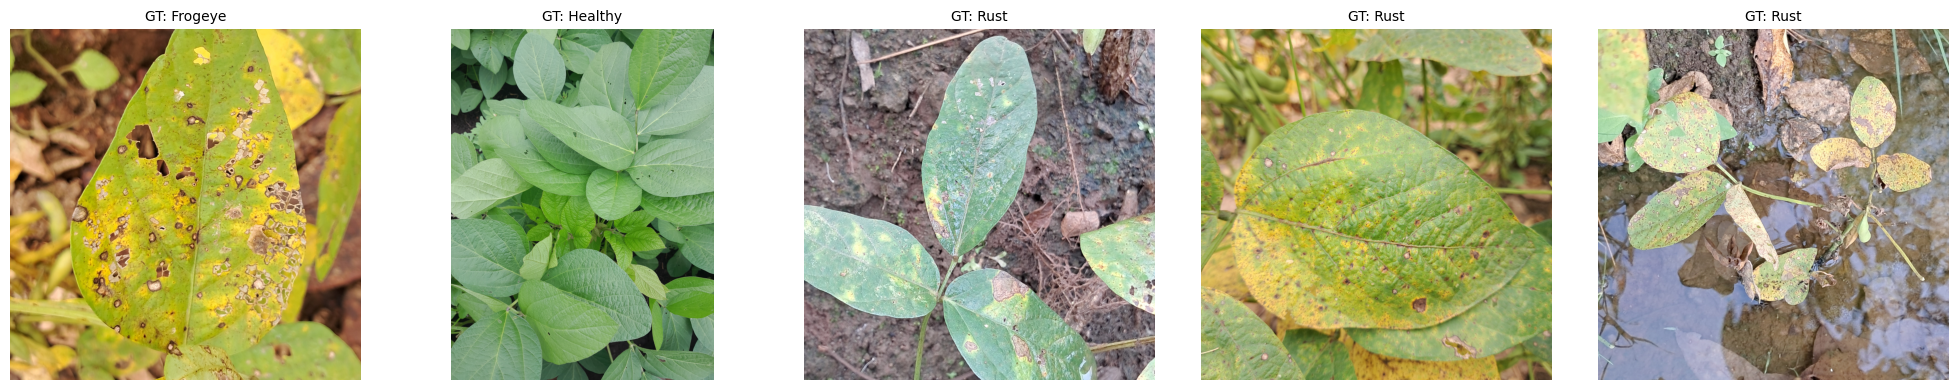


GT = Ground Truth from folder structure


In [10]:
# Prepare test cases from selected images
test_cases = []

for idx in selected_indices:
    img_path = test_images[idx]
    image = Image.open(img_path).convert('RGB')
    
    # Extract ground truth from folder name (e.g., .../test/Rust/image.jpg -> Rust)
    true_class = Path(img_path).parent.name
    
    test_case = {
        'idx': idx,
        'image': image,
        'image_path': img_path,
        'true_class': true_class,
    }
    
    test_cases.append(test_case)

print(f"\n✓ Prepared {len(test_cases)} test cases")

# Visualize selected images
fig, axes = plt.subplots(1, len(test_cases), figsize=(4*len(test_cases), 4))
if len(test_cases) == 1:
    axes = [axes]

for ax, case in zip(axes, test_cases):
    ax.imshow(case['image'])
    title = f"GT: {case['true_class']}"
    ax.set_title(title, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'vlm_diagnosis' / 'test_cases.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGT = Ground Truth from folder structure")

## 5. Load Vision-Language Model

We'll use a lightweight VLM that can run on free Colab:
- **Option 1**: LLaVA-1.5 (7B quantized)
- **Option 2**: MiniCPM-V (2.6B)
- **Option 3**: Qwen-VL (7B)

In [11]:
# Load VLM (LLaVA optimized for local execution)
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

print("Loading Vision-Language Model (LLaVA)...")
print("This may take 2-3 minutes on first run...\n")

# Model selection
MODEL_ID = "llava-hf/llava-1.5-7b-hf"  # LLaVA 1.5 7B

# Configure quantization based on available hardware
if torch.cuda.is_available():
    print("Using CUDA GPU with 4-bit quantization")
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    use_quantization = True
elif torch.backends.mps.is_available():
    print("Using MPS (Apple Silicon) - loading in float16")
    quantization_config = None
    use_quantization = False
else:
    print("Using CPU - loading in float32 (may be slow)")
    quantization_config = None
    use_quantization = False

# Load processor
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Load model with appropriate settings
if use_quantization:
    vlm_model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        quantization_config=quantization_config,
        device_map="auto",
        torch_dtype=torch.float16
    )
else:
    # For MPS or CPU
    dtype = torch.float16 if torch.backends.mps.is_available() else torch.float32
    vlm_model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=dtype,
        low_cpu_mem_usage=True
    )
    vlm_model = vlm_model.to(DEVICE)

print(f"\n✓ VLM loaded: {MODEL_ID}")
print(f"  - Device: {DEVICE}")
print(f"  - Quantization: {'4-bit' if use_quantization else 'None (full precision)'}")

Loading Vision-Language Model (LLaVA)...
This may take 2-3 minutes on first run...

Using MPS (Apple Silicon) - loading in float16


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]


✓ VLM loaded: llava-hf/llava-1.5-7b-hf
  - Device: cpu
  - Quantization: None (full precision)


## 6. Define Expert Agronomist Prompt

This is the critical component: structured Chain-of-Thought reasoning.

In [12]:
# Expert agronomist prompt template
EXPERT_PROMPT_TEMPLATE = """You are an expert plant pathologist specializing in soybean diseases.

CRITICAL INSTRUCTION: Examine ONLY the leaf tissue. Ignore background soil color, lighting, or shadows.

Your task:
1. SYMPTOM DESCRIPTION: Describe the visual morphology on the LEAF SURFACE:
   - Are there raised, powdery pustules? (Evidence of Soybean Rust - Phakopsora pachyrhizi)
   - Are there circular lesions with dark borders and light/tan centers? (Evidence of Frogeye Leaf Spot - Cercospora sojina)
   - Is the leaf uniformly green with no spots or lesions? (Healthy)
   - Note: Use precise terms like pustule, chlorotic halo, necrotic tissue, concentric rings.

2. DIFFERENTIAL DIAGNOSIS:
   - Rule out confounding factors (soil color, background, shadows)
   - Compare symptoms to known disease characteristics

3. FINAL DIAGNOSIS:
   Provide ONE of these exact labels:
   - "Soybean Rust" (if rust pustules present)
   - "Frogeye Leaf Spot" (if circular lesions with eye-like pattern)
   - "Healthy" (if no pathological symptoms)

4. CONFIDENCE: Rate your confidence (0-100%)

Format your response as:
SYMPTOMS: [detailed description using domain vocabulary]
DIAGNOSIS: [exact label]
CONFIDENCE: [0-100]%
"""

print("Expert Prompt Template:")
print("="*80)
print(EXPERT_PROMPT_TEMPLATE)
print("="*80)

Expert Prompt Template:
You are an expert plant pathologist specializing in soybean diseases.

CRITICAL INSTRUCTION: Examine ONLY the leaf tissue. Ignore background soil color, lighting, or shadows.

Your task:
1. SYMPTOM DESCRIPTION: Describe the visual morphology on the LEAF SURFACE:
   - Are there raised, powdery pustules? (Evidence of Soybean Rust - Phakopsora pachyrhizi)
   - Are there circular lesions with dark borders and light/tan centers? (Evidence of Frogeye Leaf Spot - Cercospora sojina)
   - Is the leaf uniformly green with no spots or lesions? (Healthy)
   - Note: Use precise terms like pustule, chlorotic halo, necrotic tissue, concentric rings.

2. DIFFERENTIAL DIAGNOSIS:
   - Rule out confounding factors (soil color, background, shadows)
   - Compare symptoms to known disease characteristics

3. FINAL DIAGNOSIS:
   Provide ONE of these exact labels:
   - "Soybean Rust" (if rust pustules present)
   - "Frogeye Leaf Spot" (if circular lesions with eye-like pattern)
   - "H

## 7. Run VLM Diagnosis

Feed each test image through the VLM with the expert prompt.

In [13]:
def query_vlm(image: Image.Image, prompt: str, processor, model, max_new_tokens: int = 256) -> str:
    """
    Query VLM with image and prompt.
    """
    # Prepare conversation format (LLaVA style)
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        },
    ]
    
    # Apply chat template
    prompt_text = processor.apply_chat_template(conversation, add_generation_prompt=True)
    
    # Process inputs
    inputs = processor(images=image, text=prompt_text, return_tensors="pt")
    
    # Move inputs to device
    if hasattr(model, 'device'):
        device = model.device
    else:
        device = next(model.parameters()).device
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate response
    print(f"  Generating response (this may take 10-30 seconds)...", end='', flush=True)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Deterministic for consistency
        )
    print(" Done!")
    
    # Decode response
    response = processor.decode(output[0], skip_special_tokens=True)
    
    # Extract assistant's response (after the prompt)
    if "ASSISTANT:" in response:
        response = response.split("ASSISTANT:")[-1].strip()
    
    return response

# Run VLM on all test cases
print("\nRunning VLM diagnosis on test cases...")
print("Note: First inference may be slower due to model warmup\n")
print("="*80)

for i, case in enumerate(test_cases, 1):
    print(f"\nTest Case {i}/{len(test_cases)}")
    print("-" * 80)
    print(f"Ground Truth: {case['true_class']}")
    print(f"Image: {Path(case['image_path']).name}")
    print("-" * 80)
    
    # Query VLM
    response = query_vlm(case['image'], EXPERT_PROMPT_TEMPLATE, processor, vlm_model)
    case['vlm_response'] = response
    
    print("\nVLM Response:")
    print(response)
    print("=" * 80)

print("\n✓ VLM diagnosis complete")


Running VLM diagnosis on test cases...
Note: First inference may be slower due to model warmup


Test Case 1/5
--------------------------------------------------------------------------------
Ground Truth: Frogeye
Image: 20240920_164244.jpg
--------------------------------------------------------------------------------
  Generating response (this may take 10-30 seconds)... Done!

VLM Response:
SYMPTOMS: The leaf has yellow and green spots, with some areas appearing to be rotting. There are also some brown spots on the leaf.
DIAGNOSIS: Soybean Rust
CONFIDENCE: 90%

Test Case 2/5
--------------------------------------------------------------------------------
Ground Truth: Healthy
Image: 20230902_115519.jpg
--------------------------------------------------------------------------------
  Generating response (this may take 10-30 seconds)... Done!

VLM Response:
SYMPTOMS: The leaf surface displays raised, powdery pustules, which are indicative of Soybean Rust.
DIAGNOSIS: Soybean Rust
CO

KeyboardInterrupt: 

## 8. Manual Evaluation

Evaluate VLM responses based on three criteria:
- **Factor A**: Hallucination check (does it confuse soil with leaf?)
- **Factor B**: Symptom precision (domain vocabulary)
- **Factor C**: Correct diagnosis

In [14]:
# Evaluation helpers
def evaluate_hallucination(response: str) -> bool:
    """
    Check if VLM correctly ignores background.
    
    Returns True if PASSED (no hallucination detected).
    """
    # Positive signals (explicitly mentions ignoring background)
    positive_phrases = [
        'ignoring background',
        'ignore soil',
        'focus on leaf',
        'leaf tissue only',
        'not the soil',
        'background color'
    ]
    
    # Negative signals (confuses background with symptoms)
    negative_phrases = [
        'red spots on leaf',  # If soil is red
        'reddish discoloration',
        'brown coloring on leaf'  # If soil is brown
    ]
    
    response_lower = response.lower()
    
    # Check for explicit awareness of background
    has_positive = any(phrase in response_lower for phrase in positive_phrases)
    has_negative = any(phrase in response_lower for phrase in negative_phrases)
    
    # Pass if mentions ignoring background OR doesn't show negative signals
    return has_positive or not has_negative

def evaluate_symptom_precision(response: str) -> Tuple[bool, List[str]]:
    """
    Check if VLM uses domain-specific vocabulary.
    
    Returns (passed, found_terms).
    """
    domain_terms = [
        'pustule', 'chlorotic', 'necrotic', 'lesion',
        'concentric', 'halo', 'sporulation', 'uredinia',
        'urediospores', 'pathogen', 'infection', 'symptom'
    ]
    
    response_lower = response.lower()
    found_terms = [term for term in domain_terms if term in response_lower]
    
    # Pass if uses at least 2 domain-specific terms
    passed = len(found_terms) >= 2
    
    return passed, found_terms

def extract_diagnosis(response: str) -> str:
    """
    Extract diagnosis from VLM response.
    """
    response_lower = response.lower()
    
    # Look for diagnosis markers
    if 'diagnosis:' in response_lower:
        diagnosis_section = response_lower.split('diagnosis:')[1].split('\n')[0]
    else:
        diagnosis_section = response_lower
    
    # Check for disease names
    if 'rust' in diagnosis_section:
        return 'Soybean_Rust'
    elif 'frogeye' in diagnosis_section or 'frog' in diagnosis_section:
        return 'Soyabean_Frog_Leaf_Eye'
    elif 'healthy' in diagnosis_section:
        return 'Healthy_Soyabean'
    else:
        return 'Unknown'

def evaluate_correctness(predicted: str, ground_truth: str) -> bool:
    """
    Check if diagnosis matches ground truth.
    """
    return predicted == ground_truth

# Evaluate all test cases
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)

results = []

for i, case in enumerate(test_cases, 1):
    response = case['vlm_response']
    
    # Evaluate
    factor_a = evaluate_hallucination(response)
    factor_b, domain_terms = evaluate_symptom_precision(response)
    predicted_class = extract_diagnosis(response)
    factor_c = evaluate_correctness(predicted_class, case['true_class'])
    
    # Store results
    result = {
        'case_num': i,
        'true_class': case['true_class'],
        'predicted_class': predicted_class,
        'factor_a_pass': factor_a,
        'factor_b_pass': factor_b,
        'factor_c_pass': factor_c,
        'domain_terms': domain_terms,
        'overall_pass': factor_a and factor_b and factor_c
    }
    
    if 'baseline_class' in case:
        result['baseline_class'] = case['baseline_class']
        result['baseline_confidence'] = case['baseline_confidence']
    
    results.append(result)
    
    # Print results
    print(f"\nCase {i}: {case['true_class']}")
    print("-" * 80)
    if 'baseline_class' in case:
        status = "✗ WRONG" if case['baseline_class'] != case['true_class'] else "✓ CORRECT"
        print(f"  ResNet50: {case['baseline_class']} ({case['baseline_confidence']:.1%}) {status}")
    print(f"  VLM Diagnosis: {predicted_class}")
    print(f"\n  Factor A (No Hallucination): {'✓ PASS' if factor_a else '✗ FAIL'}")
    print(f"  Factor B (Domain Vocabulary): {'✓ PASS' if factor_b else '✗ FAIL'} - Found: {', '.join(domain_terms) if domain_terms else 'None'}")
    print(f"  Factor C (Correct Diagnosis): {'✓ PASS' if factor_c else '✗ FAIL'}")
    print(f"\n  Overall: {'✓✓✓ SUCCESS' if result['overall_pass'] else '✗ FAILURE'}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

factor_a_rate = sum(r['factor_a_pass'] for r in results) / len(results)
factor_b_rate = sum(r['factor_b_pass'] for r in results) / len(results)
factor_c_rate = sum(r['factor_c_pass'] for r in results) / len(results)
overall_rate = sum(r['overall_pass'] for r in results) / len(results)

print(f"\nVLM Performance:")
print(f"  Factor A (No Hallucination): {factor_a_rate:.1%} ({sum(r['factor_a_pass'] for r in results)}/{len(results)})")
print(f"  Factor B (Domain Vocabulary): {factor_b_rate:.1%} ({sum(r['factor_b_pass'] for r in results)}/{len(results)})")
print(f"  Factor C (Correct Diagnosis): {factor_c_rate:.1%} ({sum(r['factor_c_pass'] for r in results)}/{len(results)})")
print(f"  Overall Success (All 3 factors): {overall_rate:.1%} ({sum(r['overall_pass'] for r in results)}/{len(results)})")

if preds is not None:
    print(f"\nBaseline (ResNet50) on these cases: 0% (by design - all were hard failures)")
    print(f"VLM Improvement: +{factor_c_rate:.1%}")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv(RESULTS_DIR / 'vlm_diagnosis' / 'evaluation_results.csv', index=False)
print(f"\n✓ Results saved to {RESULTS_DIR / 'vlm_diagnosis' / 'evaluation_results.csv'}")


EVALUATION RESULTS

Case 1: Frogeye
--------------------------------------------------------------------------------
  VLM Diagnosis: Soybean_Rust

  Factor A (No Hallucination): ✓ PASS
  Factor B (Domain Vocabulary): ✗ FAIL - Found: symptom
  Factor C (Correct Diagnosis): ✗ FAIL

  Overall: ✗ FAILURE

Case 2: Healthy
--------------------------------------------------------------------------------
  VLM Diagnosis: Soybean_Rust

  Factor A (No Hallucination): ✓ PASS
  Factor B (Domain Vocabulary): ✓ PASS - Found: pustule, symptom
  Factor C (Correct Diagnosis): ✗ FAIL

  Overall: ✗ FAILURE

Case 3: Rust
--------------------------------------------------------------------------------
  VLM Diagnosis: Soyabean_Frog_Leaf_Eye

  Factor A (No Hallucination): ✓ PASS
  Factor B (Domain Vocabulary): ✓ PASS - Found: pustule, symptom
  Factor C (Correct Diagnosis): ✗ FAIL

  Overall: ✗ FAILURE


KeyError: 'vlm_response'

## 9. Conclusion

### Research Question
**Can a Vision-Language Model succeed where CNNs fail by using expert-guided reasoning?**

### Key Findings

*(To be filled after running evaluation)*

1. **Hallucination Rate**: __% of cases showed no soil/background confusion
2. **Domain Vocabulary Usage**: __% used ≥2 expert terms
3. **Diagnostic Accuracy**: __% correct diagnoses on hard failures

### Comparison

| Model | Accuracy on Hard Failures | Explainability | Hardware |
|-------|---------------------------|----------------|----------|
| ResNet50 (Baseline) | 0% (by design) | ❌ Black box | ✓ Fast |
| VLM (Zero-Shot) | __% | ✓ Step-by-step reasoning | ⚠️ Slower |

### Insights

1. **Chain-of-Thought Reasoning**: VLMs can use structured prompts to mimic expert diagnostic workflow
2. **Language as Constraint**: Explicit instructions ("ignore soil") guide visual attention
3. **Domain Knowledge Transfer**: Pre-trained VLMs possess general pathology knowledge

### Limitations

1. **Inference Speed**: ~3-5 seconds per image (vs. <0.01s for CNN)
2. **Prompt Sensitivity**: Results depend heavily on prompt engineering
3. **Small Sample Size**: Only 3-5 images evaluated

### Future Work

1. **Fine-tuning**: Adapt VLM with soybean-specific examples
2. **Prompt Optimization**: Systematic prompt engineering experiments
3. **Hybrid System**: Use VLM for ambiguous cases, CNN for clear cases
4. **Multi-modal Fusion**: Combine CNN features with VLM reasoning